<a href="https://colab.research.google.com/github/maximmillion/ConvCancer/blob/main/PT_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Getting the tools ready:

In [1]:
from __future__ import print_function, division
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from torchsummary import summary
import copy, shutil

cudnn.benchmark = True

### Data Loading and Preparation:

In [4]:
### loading the data from stored device
dataDict = {'class':[], 
            'filename': []}
dataPath = '/content/drive/MyDrive/cancer_dataG'
labels = os.listdir(dataPath)
for label in labels:
  localPath = os.path.join(dataPath, label)
  imagesInPath = os.listdir(localPath)
  for imagePath in imagesInPath:
    imgPath = os.path.join(localPath, imagePath)
    dataDict['class'].append(label[:-4])
    dataDict['filename'].append(imgPath)

data = pd.DataFrame(dataDict)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
X = data['filename']
y = data['class']

### Spliting the data in Train and Validation

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_val, xt,yt      =train_test_split(X,
                                             y,
                                             test_size=0.2,
                                             random_state=8)

In [7]:
# to confirm that train and test data has same classes
xt.nunique() == yt.nunique()

True

#### Separating images in train and test folders

In [8]:
!rm -r CancerData
os.mkdir('CancerData')

rm: cannot remove 'CancerData': No such file or directory


In [9]:
test_dir = "/content/CancerData/val/"
!rm -r {test_dir}
os.mkdir(test_dir)
for img_pth in X_val.tolist():
  dir = test_dir + img_pth.split('/')[-2]+'/'
  if not os.path.exists(dir):
    os.mkdir(dir)
  shutil.copy(img_pth,dir)

rm: cannot remove '/content/CancerData/val/': No such file or directory


In [10]:
train_dir = "/content/CancerData/train/"
!rm -r {train_dir}
os.mkdir(train_dir)
for img_pth in X_train.tolist():
  dir = train_dir + img_pth.split('/')[-2]+'/'
  if not os.path.exists(dir):
    os.mkdir(dir)
  shutil.copy(img_pth,dir)

rm: cannot remove '/content/CancerData/train/': No such file or directory


In [11]:
# How many images in each folder?
# Walk through test data directory and list number of files
for dirpath, dirnames, filenames in os.walk(test_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in '/content/CancerData/val/'.
There are 0 directories and 50 images in '/content/CancerData/val/stage_3_png'.
There are 0 directories and 53 images in '/content/CancerData/val/stage_1_png'.
There are 0 directories and 47 images in '/content/CancerData/val/stage_2_png'.


In [12]:
# How many images in each folder?
# Walk through train data directory and list number of files
for dirpath, dirnames, filenames in os.walk(train_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in '/content/CancerData/train/'.
There are 0 directories and 200 images in '/content/CancerData/train/stage_3_png'.
There are 0 directories and 197 images in '/content/CancerData/train/stage_1_png'.
There are 0 directories and 203 images in '/content/CancerData/train/stage_2_png'.


### Data Preprocessing (for pytorch data pipeline)
1. Data augmentation and normalization for training
2. Just normalization for validation

In [13]:

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), ### resizing to 224 randomly
        transforms.RandomHorizontalFlip(), ### randomly fliping
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # according to imagenet dataset
    ]),
    'val': transforms.Compose([
        transforms.Resize(256), # just resizing
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # according to imagenet dataset
    ]),
}

### Preparing train and Val loaders

In [14]:
data_dir = '/content/CancerData'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### setting up training pipeline (typical pytorch flow)

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### check model architecture

In [16]:

model_conv = torchvision.models.mobilenet_v2(pretrained=False)
model_conv.cuda()
summary(model_conv, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

### Fine Tuning 

In [17]:
model_ft = models.mobilenet_v2(pretrained=True)


num_ftrs = model_ft.classifier[1].in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.01)

# Decay LR by a factor of 0.1 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [18]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=9)

Epoch 0/8
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 2.4947 Acc: 0.6217
val Loss: 0.1618 Acc: 0.9667

Epoch 1/8
----------
train Loss: 0.5319 Acc: 0.8550
val Loss: 0.2422 Acc: 0.9133

Epoch 2/8
----------
train Loss: 0.4600 Acc: 0.8483
val Loss: 0.0331 Acc: 1.0000

Epoch 3/8
----------
train Loss: 0.2659 Acc: 0.9133
val Loss: 0.0086 Acc: 1.0000

Epoch 4/8
----------
train Loss: 0.2233 Acc: 0.9083
val Loss: 0.0058 Acc: 1.0000

Epoch 5/8
----------
train Loss: 0.2432 Acc: 0.9217
val Loss: 0.0055 Acc: 1.0000

Epoch 6/8
----------
train Loss: 0.3079 Acc: 0.9117
val Loss: 0.0057 Acc: 1.0000

Epoch 7/8
----------
train Loss: 0.2995 Acc: 0.9100
val Loss: 0.0078 Acc: 1.0000

Epoch 8/8
----------
train Loss: 0.2644 Acc: 0.9050
val Loss: 0.0058 Acc: 1.0000

Training complete in 1m 5s
Best val Acc: 1.000000


### Visualize the model predictions randomly:

In [19]:
def imshow(inp, title=None):
    """cutomised method to show image on plot"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


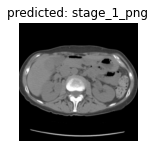

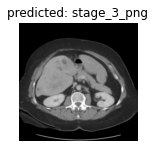

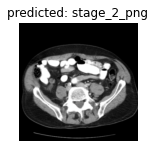

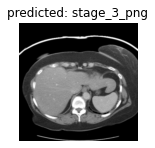

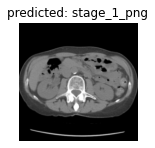

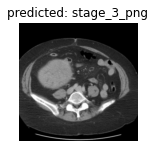

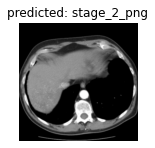

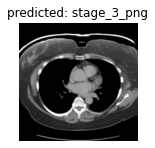

In [20]:
was_training = model_ft.training
num_images= 8
model_ft.eval()
images_so_far = 0


with torch.no_grad():
      stop=False
      for i, (inputs, labels) in enumerate(dataloaders['val']):
          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = model_ft(inputs)
          _, preds = torch.max(outputs, 1)

          for j in range(inputs.size()[0]):
              fig = plt.figure(figsize=(10, 10))
              images_so_far += 1
              ax = plt.subplot(num_images//2, 2, images_so_far)
              ax.axis('off')
              ax.set_title(f'predicted: {class_names[preds[j]]}')
              imshow(inputs.cpu().data[j])

              if images_so_far == num_images:
                  model_ft.train(mode=was_training)
                  stop=True
                  break
          if stop:
            break
          
      model_ft.train(mode=was_training)